<a href="https://colab.research.google.com/github/anglopez1996/redes_neuronales/blob/main/renet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -fr data/

In [1]:
!pip freeze | grep tensorflow

tensorflow @ https://storage.googleapis.com/cloud-tpu-tpuvm-artifacts/tensorflow/tf-2.15.0/tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl#sha256=23069418d5bea74d96f14f0ee47e8f429f0da4267df91769040a80f477e6ee05
tensorflow-datasets==4.9.4
tensorflow-estimator==2.15.0
tensorflow-hub==0.16.1
tensorflow-io-gcs-filesystem==0.36.0
tensorflow-metadata==1.14.0
tensorflow-probability==0.23.0
tensorflow-text==2.15.0


# DEPENDENCIAS

In [ ]:
# API DE KAGGLE
!pip install --upgrade --force-reinstall --no-deps kaggle

In [2]:
!pip install --upgrade --force-reinstall tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 677.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.5/821.5 kB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from kaggle.api.kaggle_api_extended import KaggleApi
from google.colab import drive
from tensorflow.keras import preprocessing as tkp
from tensorflow.keras import layers, Sequential, models, optimizers
from sklearn import metrics
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50

# DEFINICIONES

In [3]:
# Directorio Base
_BASE_FOLDER = '/content/drive/MyDrive/RNA'

# Directorio de Datos
_DATA_DIR = 'data'

# Dataset Objetivo
_DATASET_SLUG = 'hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images'

# Configuración de Kaggle
_KAGGLE_FILE = "kaggle.json"

# Ratio de aprendizaje
_LEARNING_RATE = 0.001

# Tamaño del Batch
_BATCH_SIZE = 32

# Tamaño de la Imágen
_IMAGE_SIZE = (128, 128)

# Modo de Color
_COLOR_MODE = "rgb" # Or rgb

# Semilla Aleatoria
_RANDOM_SEED = 42
tf.random.set_seed(_RANDOM_SEED)
np.random.seed(_RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(_RANDOM_SEED)

# FUNCIONES DE APOYO

In [4]:
def download_dataset_from_kaggle(*, keggle_file, dataset_slug, data_dir):
    """
    Descarga un dataset de Kaggle.

    Parámetros:
    - keggle_file: La ruta al archivo kaggle.json que contiene tus credenciales de la API de Kaggle.
    - dataset_slug: El slug del dataset en Kaggle (ejemplo: 'username/dataset-name').
    - data_dir: La ruta de la carpeta donde quieres descargar el dataset.
    """
    # Carga las credenciales de la API de Kaggle
    with open(keggle_file) as f:
        kaggle_credentials = json.load(f)

    os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
    os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

    # Inicializa la API de Kaggle y autentica
    api = KaggleApi()
    api.authenticate()

    # Descarga y descomprime el dataset
    api.dataset_download_files(dataset_slug, path=data_dir, unzip=True)
    print(f"Dataset {dataset_slug} descargado en: {data_dir}")

In [5]:
# Función para visualizar un extracto de dataset
def show_dataset_sample(*, dataset, class_names, title="", cmap=None):
  plt.figure(figsize=(6, 6))

  for images, labels in dataset.take(1):
      for i in range(9):
          ax = plt.subplot(3, 3, i + 1)
          plt.imshow(images[i].numpy().astype("uint8"), cmap=cmap)
          plt.title(class_names[tf.argmax(labels[i])])
          plt.axis("off")

  plt.suptitle(title, fontsize=12, fontweight='bold')
  plt.show()

In [6]:
def split_dataset(*, dataset, part_size):
  size = len(dataset)
  part = int(size * part_size)

  set_one = dataset.take(count=part)
  set_two = dataset.skip(count=part)

  return set_one, set_two

In [7]:
def visualize_loss_curve(H):
    epochs = len(H.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [8]:
def visualize_accuracy_curve(H):
    epochs = len(H.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [9]:
def evaluate_model(*, model, dataset):
  print("EVALUACIÓN DEL MODELO: ")
  test_loss_a, test_accuracy_a = model.evaluate(dataset)
  print(f"Test Loss: {test_loss_a}")
  print(f"Test Accuracy: {test_accuracy_a}")

  print("\nREPORTE DE CLASIFICACIÓN: ")
  predictions = model.predict(dataset)
  predicted_classes = np.argmax(predictions, axis=1)

  true_labels = []
  for _, labels in test_set.unbatch().take(-1):
    true_labels.append(np.argmax(labels.numpy()))

  report = metrics.classification_report(
    true_labels,
    predicted_classes,
    target_names=_CLASS_NAMES
  )

  print(report)

# CARGA DE DATOS

In [ ]:
# Montar GoogleDrive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Descargar el dataset objetivo.
download_dataset_from_kaggle(
    keggle_file=_KAGGLE_FILE,
    dataset_slug=_DATASET_SLUG,
    data_dir=_DATA_DIR
)

Dataset hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images descargado en: data


In [11]:
# Estandarizar nombre del directorio del dataset y verficar datos descargados.
!find data/ -mindepth 1 -maxdepth 1 -type d -exec mv {} data/dataset \;
!find data/ -type f | sed -E 's|/[^/]+$||' | sort | uniq -c

   5000 data/dataset/Boot
   5000 data/dataset/Sandal
   5000 data/dataset/Shoe


# PREPARAR DATASETS

In [10]:
# Cargar el dataset
dataset = tkp.image_dataset_from_directory(
    directory=f"{_DATA_DIR}/dataset",
    label_mode="categorical",
    color_mode=_COLOR_MODE,
    image_size=_IMAGE_SIZE,
    batch_size=None,
    shuffle=False,
    pad_to_aspect_ratio=True, # mantiene el aspecto de la imagen
)

_CLASS_NAMES = dataset.class_names

print("Clases encontradas: ", _CLASS_NAMES)

Found 15000 files belonging to 3 classes.
Clases encontradas:  ['Boot', 'Sandal', 'Shoe']


In [11]:
# Mezclar el dataset y aplicar tamaño de batch.

dataset = dataset.shuffle(
  buffer_size=dataset.cardinality(),
  seed=_RANDOM_SEED,
  reshuffle_each_iteration=False
)
dataset = dataset.batch(batch_size=_BATCH_SIZE)

dataset.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=469>

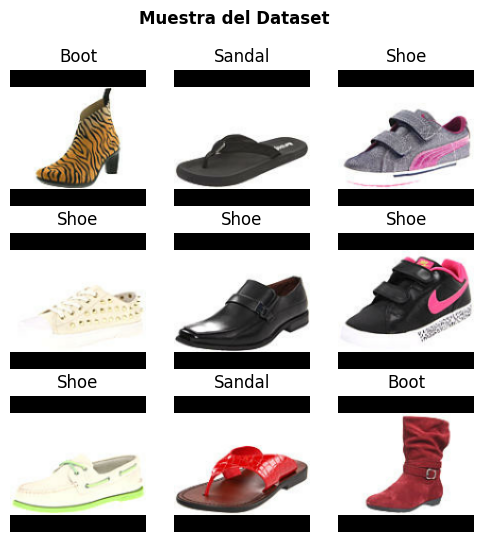

In [12]:
# Muestra del Dataset Completo
show_dataset_sample(dataset=dataset, class_names=_CLASS_NAMES, title="Muestra del Dataset", cmap="gray")

In [13]:
# Dividir el dataset en Entrenamiento y Test

train_set, test_set = split_dataset(dataset=dataset, part_size=0.8)

dataset_size = len(dataset)
train_size = len(train_set)
test_size = len(test_set)

print("Entrenamiento:", train_size, "Test:", test_size, "Total:", dataset_size)

Entrenamiento: 375 Test: 94 Total: 469


In [14]:
# Dividir el set de entramiento para obtener el set de validación

train_set, val_set = split_dataset(dataset=train_set, part_size=0.8)

train_size = len(train_set)
val_size = len(val_set)

print("Entrenamiento:", train_size, "Validación:", val_size)

Entrenamiento: 300 Validación: 75


In [15]:
# Aleatorizar los sets de entrenamiento y validación
train_set = train_set.shuffle(
  buffer_size=train_set.cardinality(),
  seed=_RANDOM_SEED,
  reshuffle_each_iteration=True
)

val_set = val_set.shuffle(
  buffer_size=val_set.cardinality(),
  seed=_RANDOM_SEED,
  reshuffle_each_iteration=True
)

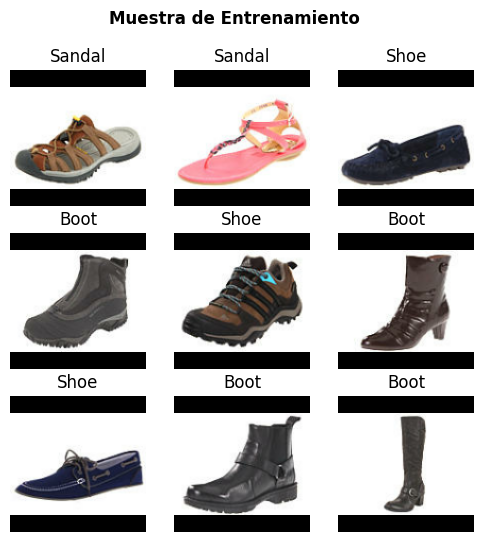

In [16]:
# Muestra del set de entrenamiento
show_dataset_sample(dataset=train_set, class_names=_CLASS_NAMES, title="Muestra de Entrenamiento", cmap="gray")

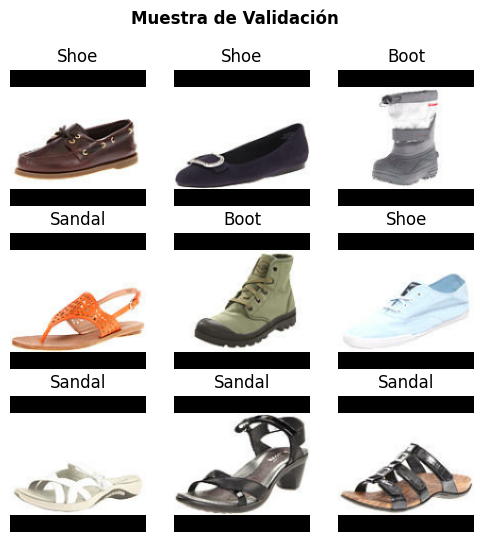

In [17]:
# Muestra del set de validación
show_dataset_sample(dataset=val_set, class_names=_CLASS_NAMES, title="Muestra de Validación", cmap="gray")

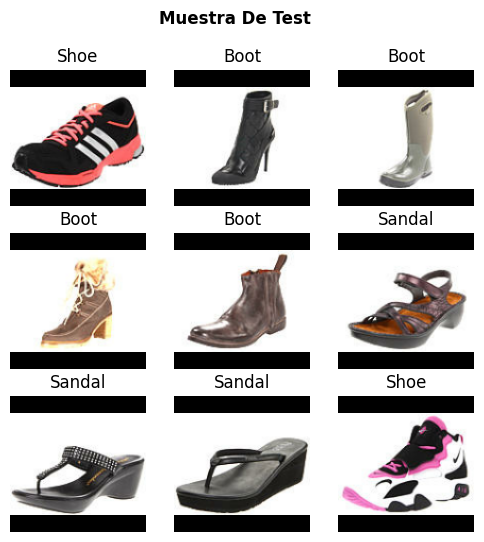

In [18]:
# Muestra del set de test
show_dataset_sample(dataset=test_set, class_names=_CLASS_NAMES, title="Muestra De Test", cmap="gray")

# DEFINICIÓN DEL MODELO

In [22]:
# Definir el modelo
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(128,128,3),
    # pooling=None,
    # classifier_activation='softmax'
)

base_model.trainable = True  # Congelar el modelo base para reducir la carga computacional

base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [23]:
# Se identifican el número de capas que tiene el modelo
for i, layer in enumerate(base_model.layers):
  print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [23]:
# Congelamos parcialmente
first_trained_layer = "conv5_block1_1_conv"
for layer in base_model.layers:
  if layer.name == first_trained_layer:
    break
  layer.trainable = False
  print("Capa " + layer.name + " congelada...")

Capa input_layer_1 congelada...
Capa conv1_pad congelada...
Capa conv1_conv congelada...
Capa conv1_bn congelada...
Capa conv1_relu congelada...
Capa pool1_pad congelada...
Capa pool1_pool congelada...
Capa conv2_block1_1_conv congelada...
Capa conv2_block1_1_bn congelada...
Capa conv2_block1_1_relu congelada...
Capa conv2_block1_2_conv congelada...
Capa conv2_block1_2_bn congelada...
Capa conv2_block1_2_relu congelada...
Capa conv2_block1_0_conv congelada...
Capa conv2_block1_3_conv congelada...
Capa conv2_block1_0_bn congelada...
Capa conv2_block1_3_bn congelada...
Capa conv2_block1_add congelada...
Capa conv2_block1_out congelada...
Capa conv2_block2_1_conv congelada...
Capa conv2_block2_1_bn congelada...
Capa conv2_block2_1_relu congelada...
Capa conv2_block2_2_conv congelada...
Capa conv2_block2_2_bn congelada...
Capa conv2_block2_2_relu congelada...
Capa conv2_block2_3_conv congelada...
Capa conv2_block2_3_bn congelada...
Capa conv2_block2_add congelada...
Capa conv2_block2_out c

In [24]:
# Conectar el modelo con el top model
ft_model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation="relu"), #probar quitandolo
    layers.Dropout(0.5),  # Añadir dropout para regularización probar quitandolo
    layers.Dense(3, activation="softmax")
])

ft_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ ?                           │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 14,976,000 (57.13 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

In [25]:
# ·Ahora entrenamos este modelo inicial
from tensorflow.keras.optimizers import Adam

# Compilar el modelo inicial
ft_model.compile(optimizer=Adam(learning_rate=1e-4),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# Entrenar el modelo inicial
history_initial = ft_model.fit(
    train_set,
    epochs=10,
    validation_data=val_set
)


Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 136s 416ms/step - accuracy: 0.8726 - loss: 0.3153 - val_accuracy: 0.9833 - val_loss: 0.0540
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 122s 405ms/step - accuracy: 0.9943 - loss: 0.0225 - val_accuracy: 0.9875 - val_loss: 0.0503
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 122s 406ms/step - accuracy: 0.9975 - loss: 0.0097 - val_accuracy: 0.9858 - val_loss: 0.0646
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 123s 408ms/step - accuracy: 0.9995 - loss: 0.0032 - val_accuracy: 0.9892 - val_loss: 0.0627
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 124s 412ms/step - accuracy: 0.9961 - loss: 0.0115 - val_accuracy: 0.9887 - val_loss: 0.0622
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 124s 413ms/step - accuracy: 0.9990 - loss: 0.0043 - val_accuracy: 0.9887 - val_loss: 0.0668
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 124s 412ms/step - accuracy: 0.9993 - loss: 0.0035 - val_accuracy: 0.9896 - val_loss: 0.0494
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 124s 412ms/step - accuracy: 0.9989 -

------

In [ ]:
# # Callbacks

# # Configuración del EarlyStopping
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_accuracy',
#     patience=10,
#     verbose=1,
#     restore_best_weights=True
# )

# # Configuración del ReduceLROnPlateau
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=10,
#     verbose=1,
#     min_lr=0.0001
# )


In [ ]:
# # Entrenar el modelo.
# H = model.fit(
#     train_set,
#     validation_data=val_set,
#     epochs=100,
#      callbacks=[early_stopping, reduce_lr]
# )

Epoch 1/100
300/300 [==============================] - 15s 43ms/step - loss: 0.3862 - accuracy: 0.8480 - val_loss: 0.5333 - val_accuracy: 0.7733 - lr: 0.0010
Epoch 2/100
300/300 [==============================] - 13s 43ms/step - loss: 0.2109 - accuracy: 0.9253 - val_loss: 0.4246 - val_accuracy: 0.8325 - lr: 0.0010
Epoch 3/100
300/300 [==============================] - 13s 40ms/step - loss: 0.1633 - accuracy: 0.9433 - val_loss: 0.5961 - val_accuracy: 0.7546 - lr: 0.0010
Epoch 4/100
300/300 [==============================] - 13s 41ms/step - loss: 0.1408 - accuracy: 0.9517 - val_loss: 0.1534 - val_accuracy: 0.9575 - lr: 0.0010
Epoch 5/100
300/300 [==============================] - 13s 40ms/step - loss: 0.1072 - accuracy: 0.9642 - val_loss: 0.2247 - val_accuracy: 0.9283 - lr: 0.0010
Epoch 6/100
300/300 [==============================] - 13s 40ms/step - loss: 0.0957 - accuracy: 0.9690 - val_loss: 0.2147 - val_accuracy: 0.9217 - lr: 0.0010
Epoch 7/100
300/300 [==============================]

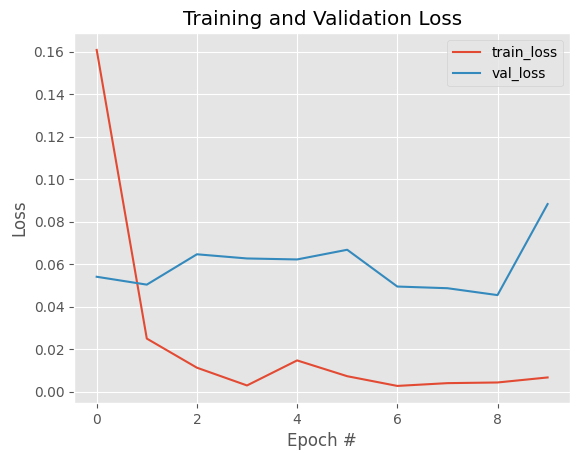

In [26]:
# Curva de aprendizaje
visualize_loss_curve(history_initial)

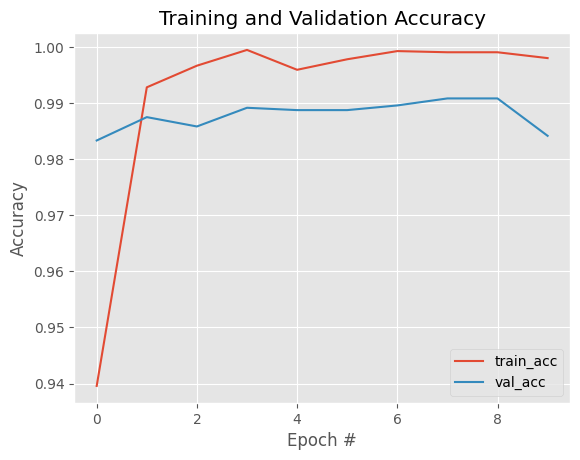

In [27]:
# Curva de precisión
visualize_accuracy_curve(history_initial)

In [28]:
evaluate_model(dataset=test_set, model=ft_model)

EVALUACIÓN DEL MODELO: 
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 220ms/step - accuracy: 0.9759 - loss: 0.1281
Test Loss: 0.12805438041687012
Test Accuracy: 0.9789999723434448

REPORTE DE CLASIFICACIÓN: 
94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 240ms/step
              precision    recall  f1-score   support

        Boot       0.99      0.99      0.99      1021
      Sandal       0.97      0.97      0.97       991
        Shoe       0.98      0.97      0.97       988

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000

